# MIMIC-II Patient Fate

This tutorial focuses on the determination of patient fate. The goal is to detect terminal states and the corresponding origins based on pseudotime.
Very rarely does the actual real time reflect the actual progression of disease. Imagine that 100 patients come in at day 45 and get measurements done. Some will be healthy still (or recovered), some at the onset of a specific disease and some at the height of it. What we are much more interested in is a continuous transition of states (e.g. healthy to diseased to dead). This can be achieved by identifying source states (e.g. healthy) and then calculating pseudotime from this state. Based on markov chain modelling we uncover patient dynamics using [cellrank](https://cellrank.readthedocs.io/en/stable/index.html). For more details please read the [Cellrank paper](https://www.nature.com/articles/s41592-021-01346-6).

In this tutorial we will be using cellrank to:

1. Compute initial & terminal as well as intermediate macrostates of our patient landscape.
2. Infer fate proabilities towards the terminal states for each individual patient (visit).
3. Visualize feature trends along specific patient states while accounting for the continuous nature of fate determination.
4. Identify potential driver features for each identified trajectory.

A skim of the extensive and well written [cellrank documentation](https://cellrank.readthedocs.io/en/stable/index.html) is recommended. Especially the [basic tutorial](https://cellrank.readthedocs.io/en/stable/cellrank_basics.html) chapter is useful. If you are not familiar with single-cell data do not be afraid and replace cells with patients and genes with features in your mind.

This tutorial requires `cellrank` and `scvelo` to be installed. These are not dependencies of ehrapy and must be installed separately:

```bash
pip install cellrank scvelo
```

This tutorial uses the MIMIC-II IAC dataset. It was created for the purpose of a case study in the book: Secondary Analysis of Electronic Health Records, published by Springer in 2016. In particular, the dataset was used throughout Chapter 16 (Data Analysis) by Raffa J. et al. to investigate the effectiveness of indwelling arterial catheters in hemodynamically stable patients with respiratory failure for mortality outcomes. The dataset is derived from MIMIC-II, the publicly-accessible critical care database. It contains summary clinical data and outcomes for 1,776 patients.

More details on the dataset can be found here: https://physionet.org/content/mimic2-iaccd/1.0/.

This tutorial will eventually load a preprocessed version of the MIMIC-II dataset, but for now we will start from scratch.

## Importing ehrapy and setting plotting parameters

In [1]:
import ehrapy.api as ep
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cellrank as cr
from cellrank.tl.kernels import ConnectivityKernel
from cellrank.tl.kernels import PseudotimeKernel
import scvelo as scv

Unable to contact PyPI to check for the latest ehrapy version. Do you have an internet 
connection?

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/medcat/cat.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import warnings
from matplotlib import MatplotlibDeprecationWarning

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)

## Getting and preprocessing the MIMIC-II dataset

In [4]:
adata = ep.dt.mimic_2(encoded=True)

In [5]:
ep.pp.knn_impute(adata)

AnnData object with n_obs × n_vars = 1776 × 46
    obs: 'service_unit', 'day_icu_intime'
    uns: 'categoricals', 'original_values_categoricals', 'var_to_encoding'
    layers: 'original'

In [6]:
ep.pp.pca(adata)
ep.pp.neighbors(adata)
ep.tl.umap(adata)
ep.tl.leiden(adata, resolution=0.5, key_added="leiden_0_5")

... storing 'service_unit' as categorical
... storing 'day_icu_intime' as categorical


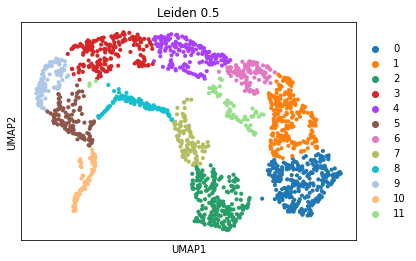

In [7]:
ep.pl.umap(adata, color=["leiden_0_5"], title="Leiden 0.5")

# Determining patient fate using a ConnectivityKernel

## Connectivity Kernels and stream embeddings

Depending on the data it may not always be possible to clearly define a cluster or specific patients as the origin. When working with single-cell data this is easier because when stem cells are detected these are usually the origin of cell differentiation processes.

In our case we do not have any clear origin and will therefore start with [cellrank's ConnectivityKernel](https://cellrank.readthedocs.io/en/stable/classes.html#connectivity-kernel). This kernel computes transition probabilities based on similarities among patients using a KNN graph.

First we define the kernel, compute the transition matrix and a projection ontop of the UMAP.

In [10]:
ck = ConnectivityKernel(adata)
ck.compute_transition_matrix()
ck.compute_projection(basis="umap")

Note that ConnectivityKernel has a `backward` parameter which can be set to `True` to compute everything backwards in time.

We can now visualize the project forwards and backwards in time using [scvelo](https://scvelo.readthedocs.io/).

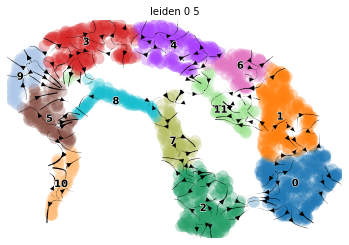

In [11]:
scv.pl.velocity_embedding_stream(adata, vkey="T_fwd", basis="umap", color="leiden_0_5")

We observe that several clusters including e.g. 8 only really have outgoing arrows indicating steady states.

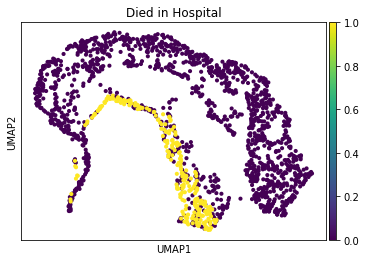

In [14]:
ep.pl.umap(adata, color="hosp_exp_flg", title="Died in Hospital")

Cluster 8 is apparently the cluster where most people died and clusters 2 and 7 further include many deceased patients.

Let's try to find the origins of the "death clusters". We will now define a [GPCCA](https://cellrank.readthedocs.io/en/stable/api/cellrank.tl.estimators.GPCCA.html) estimator to predict the patient fates using the above calculated transition matrix.

## Determining macrostates and terminal states

In [15]:
g = cr.tl.estimators.GPCCA(ck)

As a first step we try to identify macrostates in the data.

In [16]:
g.compute_macrostates(n_states=10, cluster_key="leiden_0_5")

In [17]:
g.macrostates_memberships

Lineage([[1.85923897e-03, 3.73949214e-02, 5.32237569e-01, ...,
          7.55107404e-02, 4.00418320e-03, 9.61849847e-03],
         [8.96638754e-05, 6.03761335e-02, 4.37044562e-02, ...,
          2.18596746e-02, 4.29601808e-01, 1.91064709e-01],
         [8.62293783e-03, 8.19054214e-02, 1.55856418e-02, ...,
          3.88225912e-01, 1.60063836e-02, 3.43082637e-02],
         ...,
         [2.76466267e-04, 3.92307850e-02, 1.59250896e-02, ...,
          1.01934071e-01, 2.71658162e-02, 2.42522107e-02],
         [1.42506096e-04, 3.93077380e-02, 2.33792697e-02, ...,
          9.55680322e-02, 4.45866806e-02, 9.22896279e-02],
         [1.23539414e-01, 4.57408230e-01, 5.22007608e-02, ...,
          7.57522253e-02, 7.68294200e-03, 4.54377011e-02]],
  names([10, 5, 8, 7, 9, 2, 3, 4, 1, 0]))

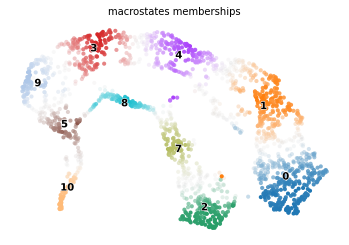

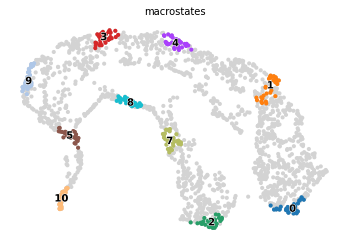

In [18]:
g.plot_macrostates()
g.plot_macrostates(discrete=True)

When calculating 10 macrostates we notice that 2, 7 and 8 have clear macrostates with many around them.

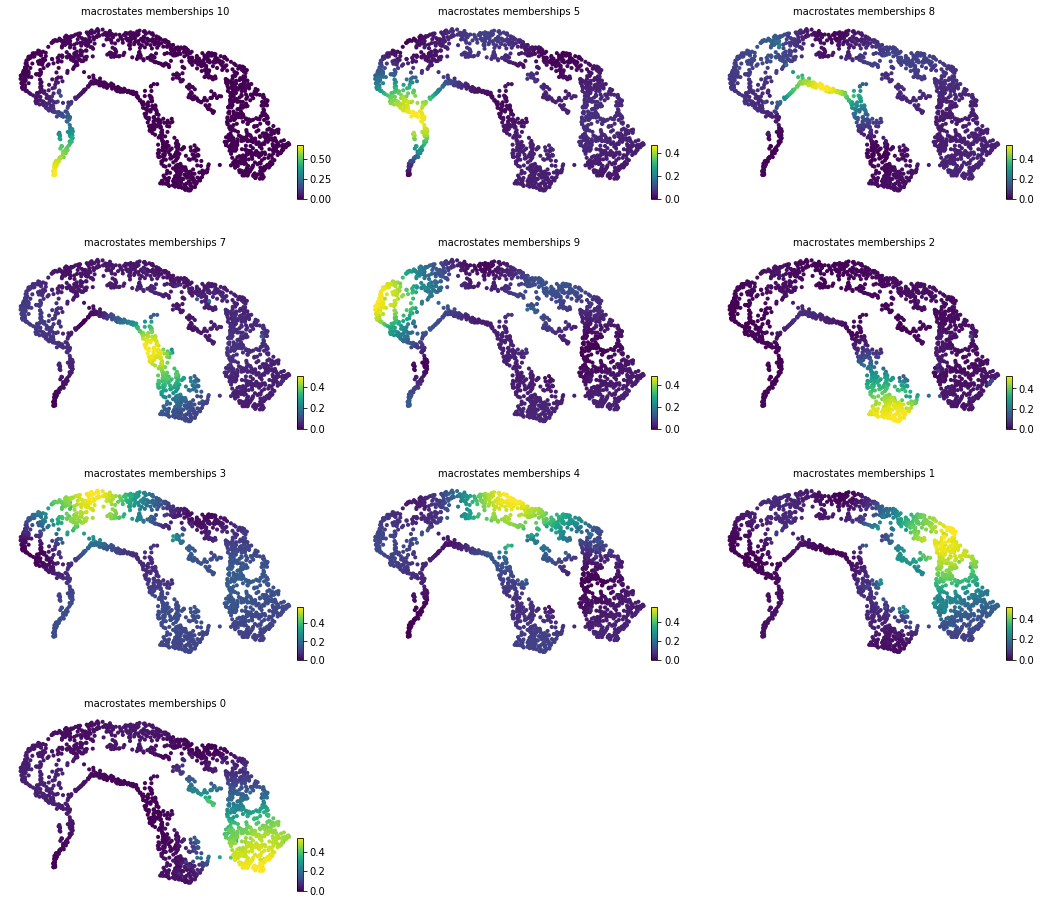

In [33]:
g.plot_macrostates(same_plot=False, ncols=3)

We will now define the macrostates 2, 7 and 8 as our terminal states.

In [24]:
g.set_terminal_states_from_macrostates(["2", "7", "8"])

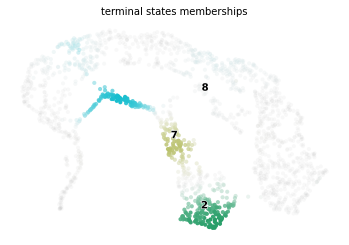

In [25]:
g.plot_terminal_states()

## Calculating absorption probabilities

As a next step we will calculate the [absorption probabilities](https://cellrank.readthedocs.io/en/stable/api/cellrank.tl.estimators.GPCCA.compute_absorption_probabilities.html#cellrank.tl.estimators.GPCCA.compute_absorption_probabilities). 

For each visit, this computes the probability of being absorbed in any of the terminal_states. In particular, this corresponds to the probability that a random walk initialized in transient visit will reach any visit from a fixed transient state before reaching a visit from any other transient state.

In [26]:
g.compute_absorption_probabilities()

Defaulting to `'gmres'` solver.


  0%|          | 0/3 [00:00<?, ?/s]

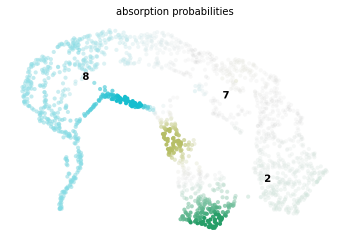

In [27]:
g.plot_absorption_probabilities()

We can also calculate a pseudotime which is required for all patient visits to reach these states.

In [30]:
g.compute_absorption_probabilities(time_to_absorption="all")
g.absorption_times

  0%|          | 0/3 [00:00<?, ?/s]

  0%|          | 0/1 [00:00<?, ?/s]

2, 7, 8 mean
0         0.000000
1       486.971741
2       545.966125
3       256.969513
4       556.640320
...            ...
1771     62.830074
1772    105.589584
1773     88.930733
1774    136.205994
1775    685.516052

[1776 rows x 1 columns]

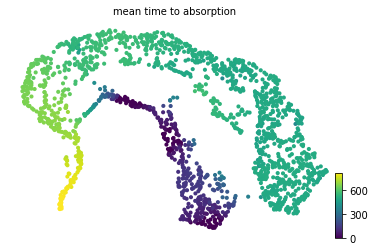

In [31]:
adata.obs["mean_time_to_absorption"] = g.absorption_times["2, 7, 8 mean"]
scv.pl.scatter(adata, color="mean_time_to_absorption")

As a next step we want to determine the major features driving these transitions and terminal states.

### Extracting lineage drivers

In [32]:
g.compute_lineage_drivers()

2_corr         2_pval  2_qval  2_ci_low  \
age                       0.201495   7.830093e-18     NaN  0.156448   
day_28_flg                0.176612   5.673255e-14     NaN  0.131176   
bun_first                 0.159913   1.107851e-11     NaN  0.114249   
hosp_exp_flg              0.155113   4.564825e-11     NaN  0.109388   
chf_flg                   0.154022   6.257784e-11     NaN  0.108284   
afib_flg                  0.119667   4.125728e-07     NaN  0.073562   
icu_exp_flg               0.119113   4.669401e-07     NaN  0.073004   
copd_flg                  0.118952   4.840652e-07     NaN  0.072841   
hour_icu_intime           0.118112   5.832398e-07     NaN  0.071994   
tco2_first                0.116559   8.207976e-07     NaN  0.070427   
resp_flg                  0.105448   8.324105e-06     NaN  0.059225   
creatinine_first          0.088732   1.796195e-04     NaN  0.042393   
potassium_first           0.083625   4.164411e-04     NaN  0.037256   
pco2_first                0.077685   1.046583e-03     NaN  0.031285   
stroke_flg                0.076698   1.212725e-03     NaN  0.030292   
renal_flg                 0.060937   1.019778e-02     NaN  0.014464   
mal_flg                   0.032713   1.682242e-01     NaN -0.013822   
platelet_first            0.030886   1.932848e-01     NaN -0.015650   
cad_flg                   0.030062   2.054389e-01     NaN -0.016475   
temp_1st                  0.023292   3.266224e-01     NaN -0.023247   
bmi                       0.019680   4.072276e-01     NaN -0.026858   
icu_los_day               0.016769   4.800918e-01     NaN -0.029768   
ehrapycat_day_icu_intime  0.015925   5.024804e-01     NaN -0.030612   
sapsi_first               0.006383   7.881128e-01     NaN -0.040143   
day_icu_intime_num       -0.000436   9.853412e-01     NaN -0.046949   
hospital_los_day         -0.002376   9.203218e-01     NaN -0.048884   
map_1st                  -0.003293   8.897303e-01     NaN -0.049799   
sodium_first             -0.005510   8.165289e-01     NaN -0.052010   
sofa_first               -0.006021   7.998735e-01     NaN -0.052519   
weight_first             -0.015079   5.254450e-01     NaN -0.061549   
abg_count                -0.018195   4.435428e-01     NaN -0.064654   
liver_flg                -0.036613   1.229835e-01     NaN -0.082986   
hgb_first                -0.042999   7.003851e-02     NaN -0.089334   
hr_1st                   -0.053644   2.376197e-02     NaN -0.099908   
chloride_first           -0.066060   5.342364e-03     NaN -0.112228   
wbc_first                -0.072184   2.328812e-03     NaN -0.118300   
aline_flg                -0.075074   1.539596e-03     NaN -0.121165   
gender_num               -0.080245   7.087512e-04     NaN -0.126288   
spo2_1st                 -0.080428   6.890013e-04     NaN -0.126469   
po2_first                -0.090859   1.248525e-04     NaN -0.136795   
ehrapycat_service_unit   -0.101271   1.878389e-05     NaN -0.147092   
service_num              -0.122847   2.004048e-07     NaN -0.168398   
mort_day_censored        -0.169885   5.070734e-13     NaN -0.214702   
censor_flg               -0.192525   2.228833e-16     NaN -0.236917   
iv_day_1                 -0.661226  1.129444e-245     NaN -0.686622   
sepsis_flg                     NaN            NaN     NaN       NaN   

                          2_ci_high    7_corr        7_pval  7_qval  7_ci_low  \
age                        0.245706  0.089295  1.632674e-04     NaN  0.042959   
day_28_flg                 0.221308  0.026090  2.718406e-01     NaN -0.020448   
bun_first                  0.204902 -0.017014  4.736988e-01     NaN -0.063477   
hosp_exp_flg               0.200182  0.026469  2.649334e-01     NaN -0.020069   
chf_flg                    0.199110  0.036354  1.256644e-01     NaN -0.010177   
afib_flg                   0.165260  0.059477  1.216303e-02     NaN  0.013000   
icu_exp_flg                0.164714  0.048521  4.088555e-02     NaN  0.002012   
copd_flg                   0.164555  0.000

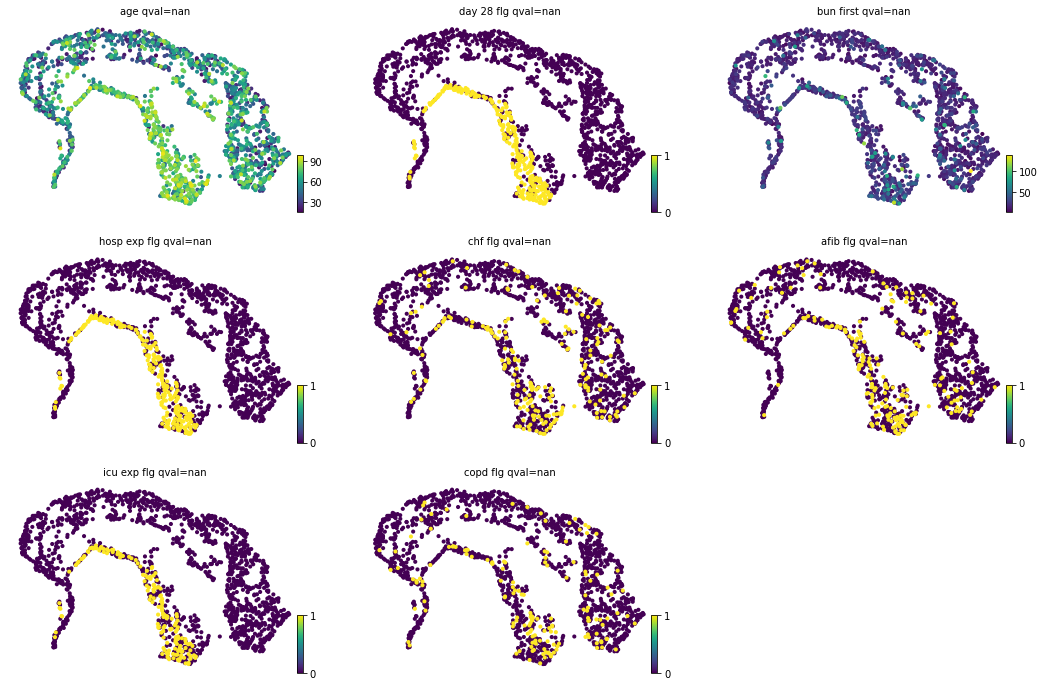

In [35]:
g.plot_lineage_drivers(lineage="2", ncols=3)

Cluster 2 seems to have a lot of patients with COPD, congestive heart failure (chf) and atrial fibrillation (afib) as a comorbidities. 

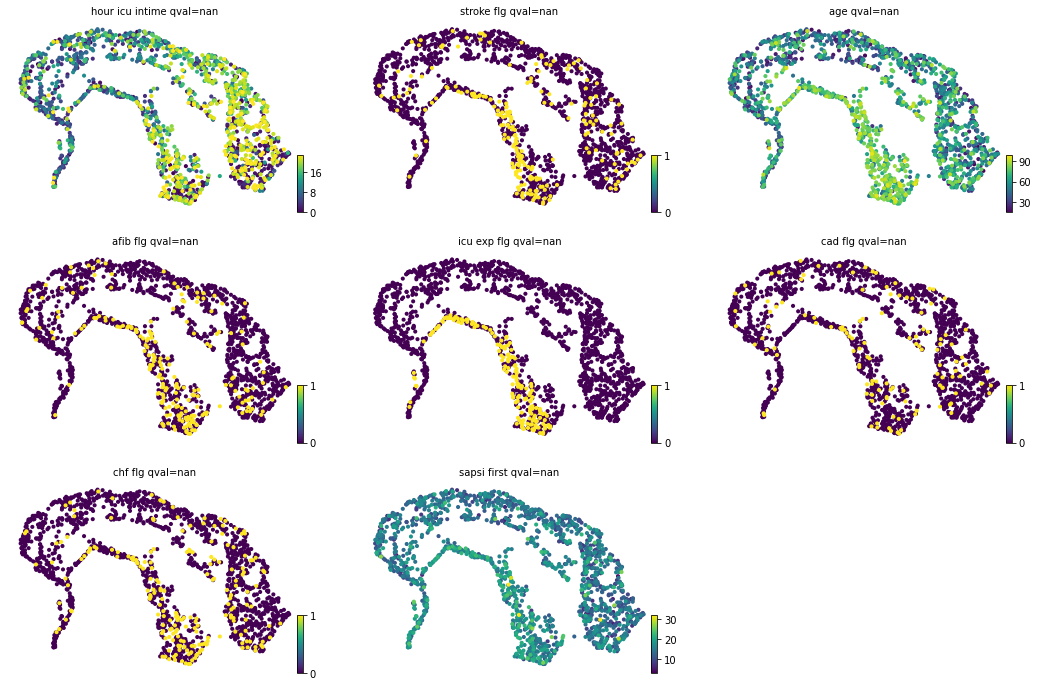

In [36]:
g.plot_lineage_drivers(lineage="7", ncols=3)

Cluster 7 is primarily influenced by atrial fibrillation (afib), coronary artery disease (cad), congestive heart failure (chf) and the SAPS I score (sapsi).

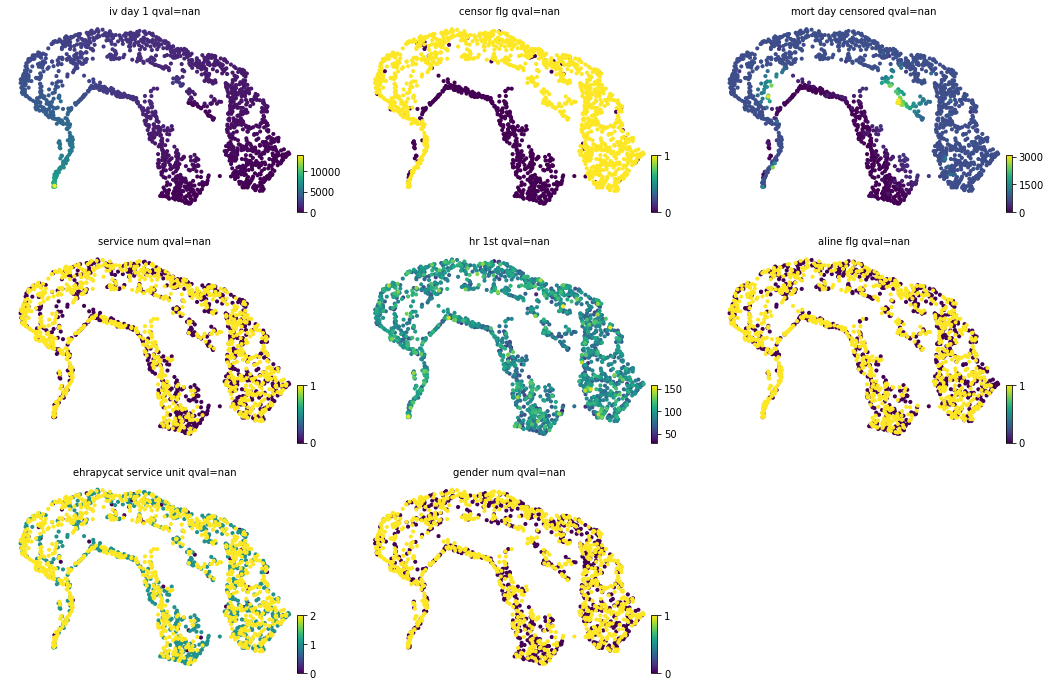

In [37]:
g.plot_lineage_drivers(lineage="8", ncols=3)

Cluster 8 is primarly defined as a terminal state by the heart rate (hr) and the IV input fluids (iv).

Although some of the features (e.g. congestive heart failure and age) overlap as drivers for death as a terminal state, all three clusters have unique origins of their macrostates.

We can also easily examine how likely it is that patients from a specific cluster end up in one of our three death dominated clusters.

## Exploring cluster fates

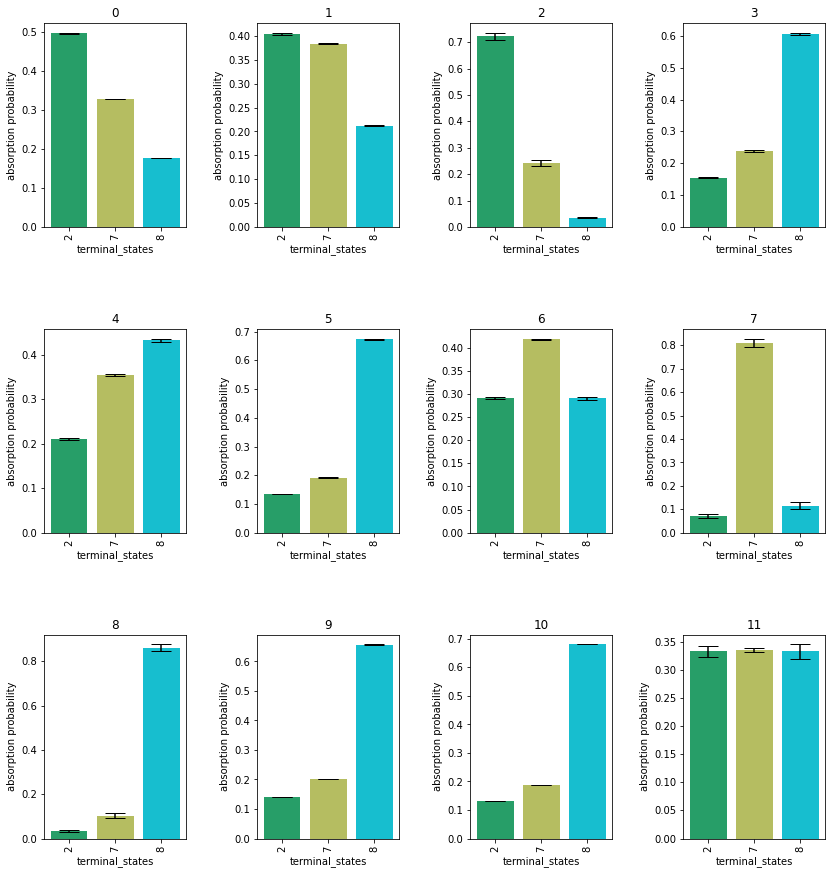

In [38]:
cr.pl.cluster_fates(adata, mode="bar", cluster_key="leiden_0_5")

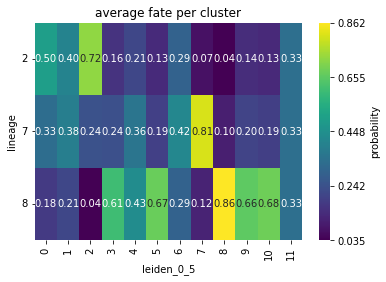

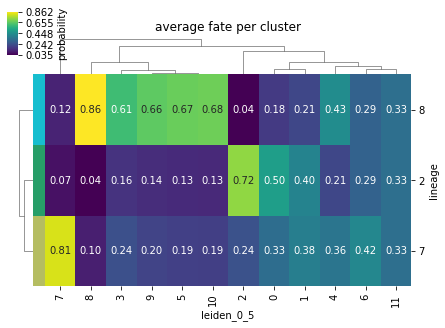

In [39]:
cr.pl.cluster_fates(adata, mode="heatmap", cluster_key="leiden_0_5")
cr.pl.cluster_fates(adata, mode="clustermap", cluster_key="leiden_0_5")

We can also leverage PAGA to visualize this information in a PAGA graph.

In [40]:
ep.tl.paga(adata, groups="leiden_0_5")

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:717: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  edge_collection = mpl.collections.LineCollection(


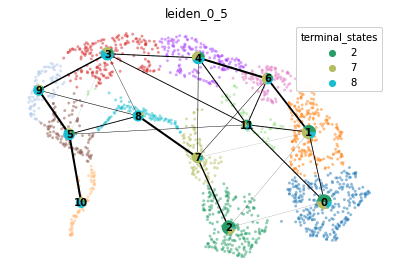

In [41]:
cr.pl.cluster_fates(adata, mode="paga_pie", basis="umap", cluster_key="leiden_0_5")

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:717: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  edge_collection = mpl.collections.LineCollection(
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:717: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  edge_collection = mpl.collections.LineCollection(
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/networkx/dra

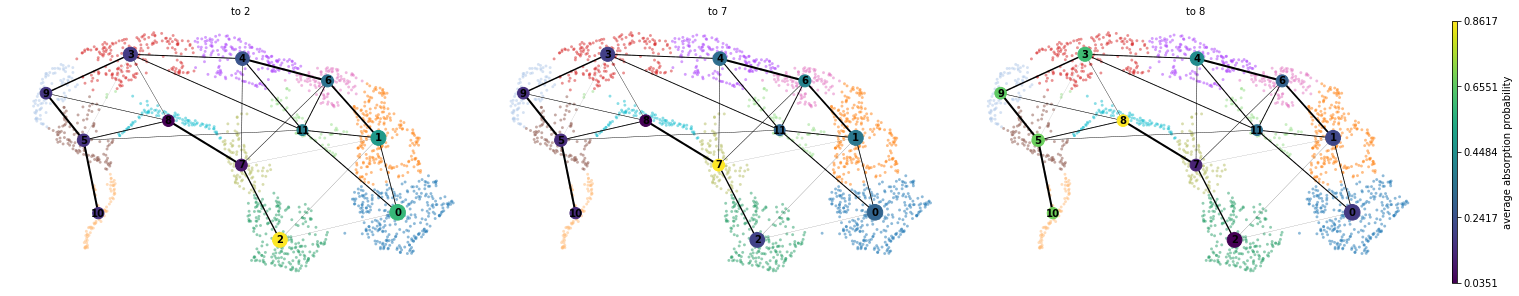

In [42]:
cr.pl.cluster_fates(adata, mode="paga", legend_loc="on data", basis="umap", cluster_key="leiden_0_5")

Finally, we can use a [circular projection](https://cellrank.readthedocs.io/en/stable/auto_examples/plotting/plot_circular_embedding.html) to represent the same information.

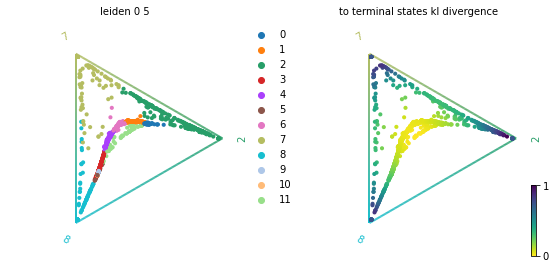

In [ ]:
cr.pl.circular_projection(
    adata, keys=["leiden_0_5", "kl_divergence"], legend_loc="upper right"
)


# Determining patient fate with a PseudotimeKernel

We have now learnt that for example death dominated cluster 2 origins from cluster 0.
Hence, we will now set a patient from cluster 0 as our root for our pseudotime calculation and will verify that we would indeed end up in cluster 2.

Using pseudotime to find terminal states is even more useful when the terminal states are unknown and only a root cluster is clear.

In [49]:
adata = ep.dt.mimic_2(encoded=True)
ep.pp.knn_impute(adata)
ep.pp.pca(adata)
ep.pp.neighbors(adata)
ep.tl.umap(adata)
ep.tl.leiden(adata, resolution=0.5, key_added="leiden_0_5")

... storing 'service_unit' as categorical
... storing 'day_icu_intime' as categorical


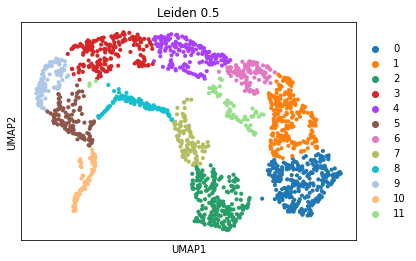

In [50]:
ep.pl.umap(adata, color=["leiden_0_5"], title="Leiden 0.5")

## Pseudotime Kernels and stream embeddings

The Pseudotime kernel computes direct transition probabilities based on a KNN graph and pseudotime.

The KNN graph contains information about the (undirected) connectivities among cells, reflecting their similarity. Pseudotime can be used to either remove edges that point against the direction of increasing pseudotime, or to downweight them.

In [51]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden_0_5'] == '0')[0]
ep.tl.dpt(adata)

In [52]:
pk = PseudotimeKernel(adata)
pk.compute_transition_matrix()
pk.compute_projection(basis="umap")

  0%|          | 0/1776 [00:00<?, ?cell/s]

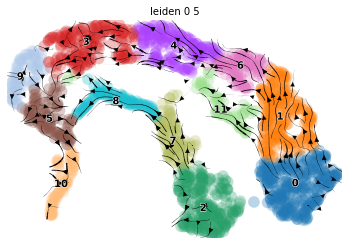

In [53]:
scv.pl.velocity_embedding_stream(adata, vkey="T_fwd", basis="umap", color="leiden_0_5")

Now the arrows are much more clear and point into the direction of cluster 2 from cluster 0.
Apparently transitions from cluster 11 to cluster 7 are possible, but also transitions via clusters 1, 6, 4, 3 and 8.

## Simulating transitions with random walks

Cellrank makes it easy to simulate the behavior of random walks from specific clusters.
This allows us to not only visualize where the patients end up, but also roughly how many in which clusters after a defined number of iterations.
We can either just start walking...

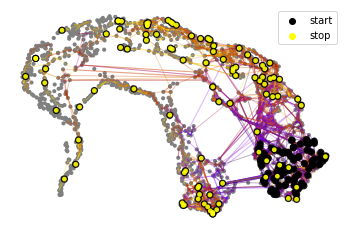

In [54]:
pk.plot_random_walks(
    100,
    start_ixs={"leiden_0_5": "0"},
    max_iter=100,
    show_progress_bar=False,
    ixs_legend_loc="best",
    seed=42,
)

... or set a number of required hits in one or more terminal clusters.
Here, we require 50 hits in one of our three "death" clusters.

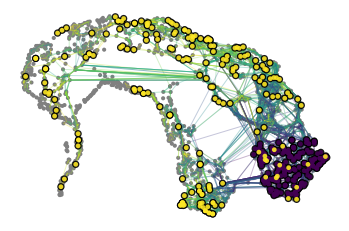

In [55]:
pk.plot_random_walks(
    200,
    start_ixs={"leiden_0_5": "0"},
    stop_ixs={"leiden_0_5": ["8", "7", "2"]},
    max_iter=100,
    successive_hits=50,
    show_progress_bar=False,
    cmap="viridis",
    seed=42,
)

## Determining macrostates and terminal states

Similarly to above when using our ConnectivityKernel we can compute macrostate memberships.

In [73]:
g = cr.tl.estimators.GPCCA(pk)
g.compute_schur()
g.compute_macrostates(cluster_key="leiden_0_5")
g.macrostates_memberships

Lineage([[7.1354640776e-08, 9.9999992865e-01],
         [1.0047882200e-02, 9.8995211780e-01],
         [5.0519049445e-08, 9.9999994948e-01],
         ...,
         [1.0000000000e+00, 0.0000000000e+00],
         [8.9336650868e-01, 1.0663349132e-01],
         [2.8911282434e-10, 9.9999999971e-01]],
  names([2, 10]))

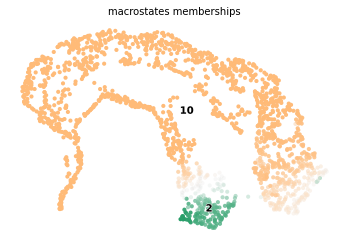

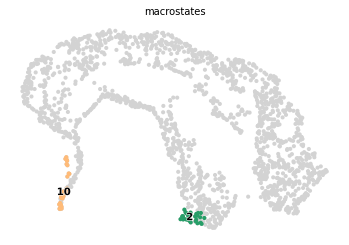

In [74]:
g.plot_macrostates()
g.plot_macrostates(discrete=True)

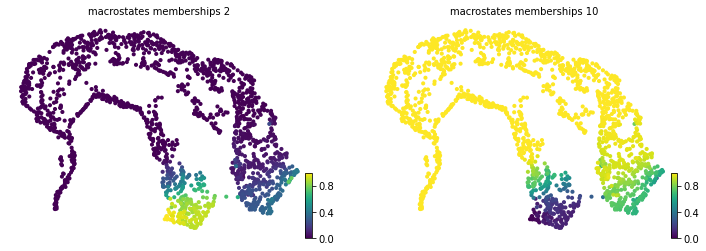

In [75]:
g.plot_macrostates(same_plot=False)

As expected cluster 2 is a macrostate. Furthermore, cluster 10 is apparently a macrostates.
This can likely be attributed to the fact that the people in cluster 10 are IV+.

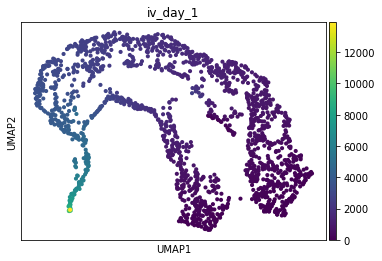

In [76]:
ep.pl.umap(adata, color="iv_day_1")

## Calculating absorption probabilities

Analogously we can compute terminal states, the absorption probabilities and the absorption times.

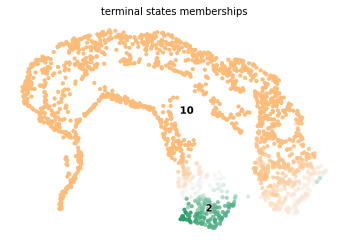

In [77]:
g.compute_terminal_states()
g.plot_terminal_states()

  0%|          | 0/2 [00:00<?, ?/s]

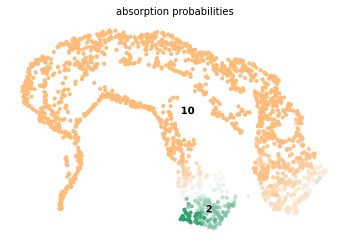

In [78]:
g.compute_absorption_probabilities(preconditioner='ilu', tol=1e-10)
g.plot_absorption_probabilities()

In [68]:
g.compute_absorption_probabilities(time_to_absorption="all", preconditioner='ilu', tol=1e-10)
g.absorption_times

  0%|          | 0/5 [00:00<?, ?/s]

  0%|          | 0/1 [00:00<?, ?/s]

0_1, 0_2, 2, 6, 10 mean
0                  179.287567
1                  112.491760
2                  286.910187
3                  146.307037
4                  262.389893
...                       ...
1771                 0.000000
1772               116.465927
1773                 0.000000
1774               107.240761
1775                87.522881

[1776 rows x 1 columns]

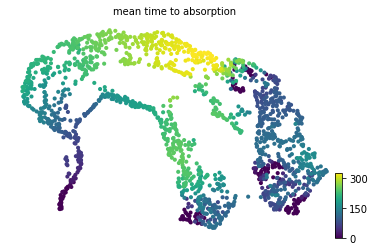

In [69]:
adata.obs["mean_time_to_absorption"] = g.absorption_times["0_1, 0_2, 2, 6, 10 mean"]
scv.pl.scatter(adata, color="mean_time_to_absorption")

## Extracting lineage drivers

Furthermore, just like above we can visualize the lineage drivers.

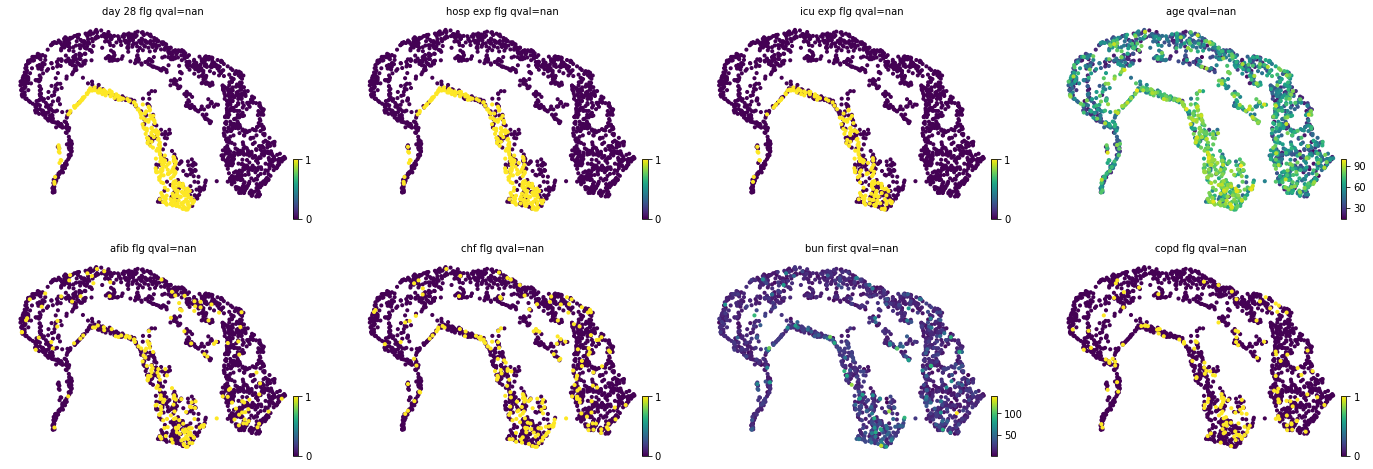

In [70]:
g.compute_lineage_drivers()
g.plot_lineage_drivers(lineage="2")

The primary lineage drivers for cluster 2 are atrial fibrillation (afib), congestive heart failure (chf), blood urea nitrogen (bun) and COPD.

## Determining feature trends

cellrank uses [Generalized Additive Models (GAMs)](https://cellrank.readthedocs.io/en/latest/api/cellrank.ul.models.GAM.html) to determine trends of features.

  0%|          | 0/1 [00:00<?, ?gene/s]

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revi

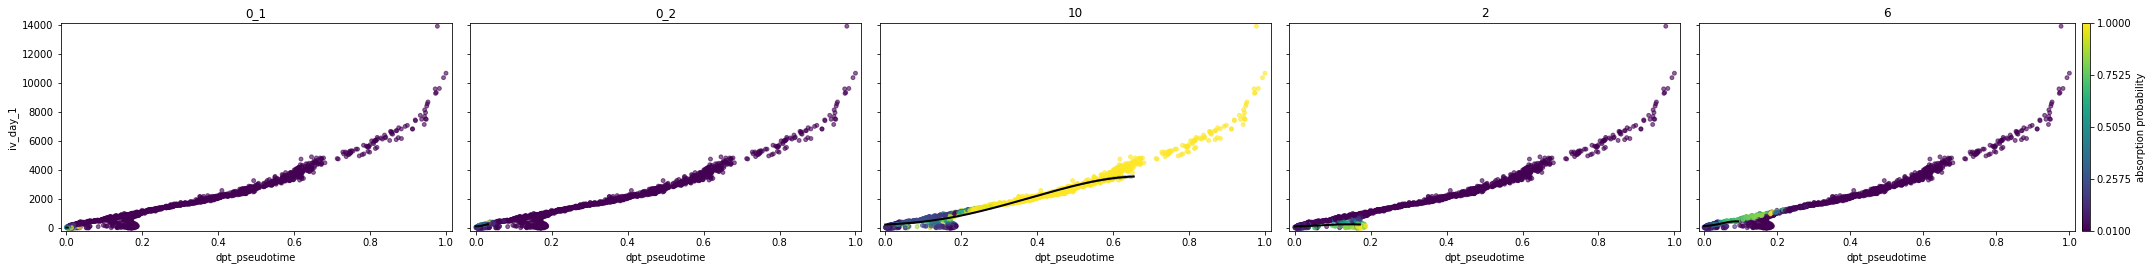

In [71]:
model = cr.ul.models.GAM(adata)
cr.pl.gene_trends(
    adata,
    model,
    ["iv_day_1"],
    time_key="dpt_pseudotime",
    show_progress_bar=False,
)

  0%|          | 0/1 [00:00<?, ?gene/s]

/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/zeth/miniconda3/envs/ehrapy/lib/python3.8/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revi

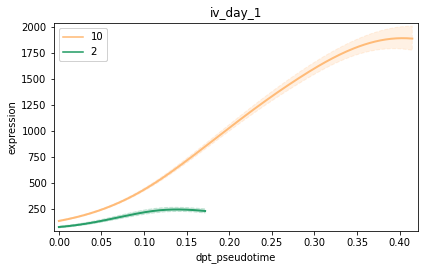

In [80]:
cr.pl.gene_trends(
    adata,
    model,
    ["iv_day_1"],
    same_plot=True,
    hide_cells=True,
    time_key="dpt_pseudotime",
    show_progress_bar=False,
)

As expected, the IV value is only marginally important for macro state 2, but even more important for macrostate 10.
This is reflected in the required pseudotime to reach macrostate 10 with increasing IV values.